In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Only need to run once
# pip install split-folders tqdm
# import splitfolders

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential, layers, models, Model, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model
from keras.preprocessing.image import image_dataset_from_directory

Load and preprocess images

In [ ]:
# Only need to run once
# pip install split-folders tqdm
# import splitfolders
# Split folders into train-validation-test. Only need to run once.
# splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/test_images", 
#                    output="/content/drive/MyDrive/Colab Notebooks/split_images", 
#                    seed=1, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 5539 files [02:55, 31.54 files/s]


In [5]:
batch_size = 32
img_height = 128
img_width = 128

In [7]:
# Rather than load the entire 5000+ image dataset, we'll use tf.data.Dataset to generate training and validation sets
train_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/val'

train_ds = image_dataset_from_directory(
  train_dir,
  seed=3,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

val_ds = image_dataset_from_directory(
  val_dir,
  seed=3,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

Found 3318 files belonging to 12 classes.
Found 1102 files belonging to 12 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


Build model

In [9]:
# Preprocess images using MobileNetV2 presets
# Includes rescaling (-1,1)
preprocess_input = mobilenet_v2.preprocess_input

# Augment data by flipping and rotating images
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

# Pool features into one dimension per image
global_average_layer = layers.GlobalAveragePooling2D()

# Add a prediction layer that matches the number of categories
prediction_layer = layers.Dense(12, activation='softmax')

In [17]:
# Employ transfer learning, specifically MobileNetV2
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    classes=12
)
# Allows training of MobileNetV2 weights
base_model.trainable = False

In [23]:
# Combine the data augmentation, preprocessing, pooling, and prediction layers with MobileNetV2 base model
inputs = Input(shape=(img_height, img_width, 3))
X = data_augmentation(inputs)
X = preprocess_input(X)
X = base_model(X, training=False)
X = global_average_layer(X)
X = Dropout(0.4)(X)
outputs = prediction_layer(X)
model = Model(inputs, outputs)

In [24]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [25]:
optimizer = Adam(learning_rate=0.001)
loss = losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

In [26]:
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=100,
          batch_size=64, 
          verbose=1,
          callbacks=mc)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


104/104 [==============================] - 1011s 10s/step - loss: 1.8202 - accuracy: 0.4030 - val_loss: 1.1507 - val_accuracy: 0.6125
Epoch 2/100
104/104 [==============================] - 31s 279ms/step - loss: 1.2559 - accuracy: 0.5766 - val_loss: 0.9125 - val_accuracy: 0.6906
Epoch 3/100
104/104 [==============================] - 29s 260ms/step - loss: 1.0395 - accuracy: 0.6462 - val_loss: 0.8289 - val_accuracy: 0.7287
Epoch 4/100
104/104 [==============================] - 29s 260ms/step - loss: 0.9407 - accuracy: 0.6682 - val_loss: 0.7501 - val_accuracy: 0.7559
Epoch 5/100
104/104 [==============================] - 29s 266ms/step - loss: 0.8656 - accuracy: 0.7016 - val_loss: 0.7303 - val_accuracy: 0.7623
Epoch 6/100
104/104 [==============================] - 29s 261ms/step - loss: 0.8168 - accuracy: 0.7179 - val_loss: 0.7123 - val_accuracy: 0.7632
Epoch 7/100
104/104 [==============================] - 29s 266ms/step - loss: 0.7885 - accuracy: 0.7266 - val_loss: 0.6798 - val_accurac

In [27]:
# Load the best model from Model Checkpoint callback (to reduce overfitting)
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/model.89-0.53.h5')

Predict and evaluate model

In [28]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/test'
test_ds = image_dataset_from_directory(
  test_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

Found 1119 files belonging to 12 classes.


In [29]:
# Acheived 80% accuracy
best_model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


35/35 [==============================] - 253s 5s/step - loss: 0.5440 - accuracy: 0.8025


[0.5440319776535034, 0.8025022149085999]

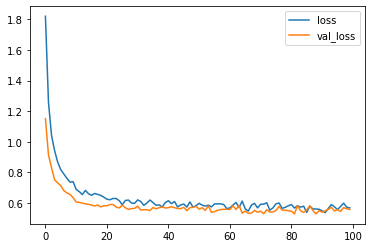

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

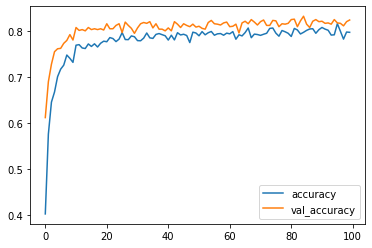

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

Save and load model

In [32]:
# From Elizabeth's Colab Notebook
best_model.save('/content/drive/MyDrive/Colab Notebooks/seedling_model.h5')


In [33]:
model_test = load_model('/content/drive/MyDrive/Colab Notebooks/seedling_model.h5')
model_test.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           